In [1]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications import vgg19,resnet50,mobilenet_v2,mobilenet,nasnet,xception,vgg16
from tensorflow.keras import backend as K
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time,argparse,cv2,glob
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
content_img = "./content/content.jpg"
style_img = "style3.jpg"

result_prefix = "gen"

iterations = 10
content_weight = 0.025
style_weight = 1


width,height = load_img(content_img).size
gen_height = 400
# Resizing width according to the height 
gen_width = int((width/height)*gen_height)

# Generated image 
generated_img = None

print("Ratio of width is to height of content image is ", (width/height))
print("Ratio of width is to height of generated image is ", (gen_width/gen_height))

Ratio of width is to height of content image is  2.1635220125786163
Ratio of width is to height of generated image is  2.1625


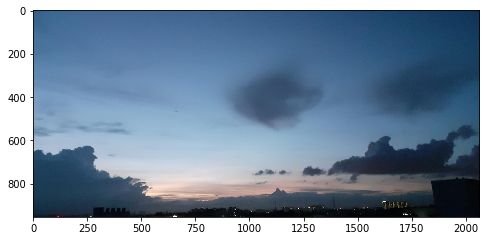

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(cv2.imread(content_img),cv2.COLOR_BGR2RGB))

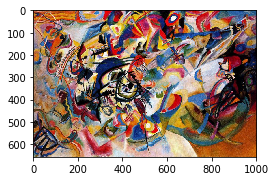

In [11]:
plt.figure(figsize=(4,4))
plt.imshow(cv2.cvtColor(cv2.imread(style_img),cv2.COLOR_BGR2RGB))

In [12]:
vgg19.preprocess_input(np.expand_dims(img_to_array(load_img(content_img,target_size=(gen_height,gen_width))),axis=0)).shape

(1, 400, 865, 3)

In [13]:

def preprocess_img(img_path):
    img = np.expand_dims(img_to_array(load_img(img_path,target_size=(gen_height,gen_width))),axis=0)
    #ret = vgg19.preprocess_input(img)
    #ret = resnet50.preprocess_input(img)
    #ret = nasnet.preprocess_input(img)
    #ret = xception.preprocess_input(img)
    ret = vgg16.preprocess_input(img)
    return ret

# converting 
def deprocess_img(img):
    img = img.reshape((gen_height,gen_width,3))
    img[:,:,0]+=103.939
    img[:,:,1]+=116.779
    img[:,:,2]+=123.68
    # BGR to RGB
    return np.clip(img[:,:,::-1],0,255).astype('uint8')

def get_input_tensor(content_img_path,style_img_path):
    # Get output tensor 
    content_tensor = K.variable(preprocess_img(content_img_path))
    style_tensor = K.variable(preprocess_img(style_img_path))
    generated_img = K.placeholder((1, gen_height, gen_width, 3))
    return generated_img,K.concatenate([content_tensor,style_tensor,generated_img],axis=0)

# Getting model with preloaded weights , where the weights are of imagenet 
def get_model(input_tensor):
    
    #model = mobilenet_v2.MobileNetV2(input_tensor = input_tensor,include_top= False)
    #model = resnet50.ResNet50(input_tensor = input_tensor,weights = 'imagenet',include_top= False)
    #model = vgg19.VGG19(input_tensor = input_tensor,weights = 'imagenet',include_top= False)
    #model = nasnet.NASNetMobile(input_tensor = input_tensor,weights = 'imagenet',include_top= False)
    #model = xception.Xception(input_tensor = input_tensor,weights = 'imagenet',include_top= False)
    model = vgg16.VGG16(input_tensor = input_tensor,weights = 'imagenet',include_top= False)
    # Layers dict 
    layer_dict = {layer.name:layer.output for layer in model.layers}
    print(model.summary())
    return model,layer_dict

# Calculating gram matrix
def gram_matrix(X):
    # Sience we have data in 3 dimension so we have to convert it to two dimension 
    # If the feature size is (512,25,40) than it will convert to (512,1000)
    f = K.batch_flatten(K.permute_dimensions(X,(2,0,1)))
    # Gram matrix is simpley the dot produt , i.e correlation b/w two vectors
    # Thus the resultant of dot product b/w 100*512 and 512*1000 will be 512*512
    return K.dot(f,K.transpose(f))

# Compares the loss b/w style image and generated image
def style_loss(style,genetated):
    assert K.ndim(style) == 3
    assert K.ndim(genetated) == 3
    
    S = gram_matrix(style)
    C = gram_matrix(genetated)
    channels = 3
    size = gen_width * gen_height
    return K.sum(K.square(S-C))/(4*(channels**2)*(size**2))

# Compares the loss b/w content and generated image
def content_loss(content,generated):
    return K.sum(K.square(generated-content))


# Evaluating loss
def eval_loss_and_grads(x,kers_func):
    grad_value = None
    x= x.reshape((1,gen_height,gen_width,3))
    
    outs = kers_func([x])
    
    loss_val = outs[0]
    if(len(outs[1:])==1):
        grad_val = outs[1].flatten().astype('float64')
    else:
        grad_val = np.array(outs[1:]).flatten().astype('float64')
    return loss_val,grad_val

In [14]:
generated_img,input_tensor = get_input_tensor(content_img,style_img)
model,layer_dict = get_model(input_tensor)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (3, 400, 865, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 865, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 865, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 432, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 432, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 432, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 216, 128)        0         
__________

In [15]:
generated_img

<tf.Tensor 'Placeholder:0' shape=(1, 400, 865, 3) dtype=float32>

In [16]:
#layer_feature = layer_dict["stem_conv1"]
layer_feature = layer_dict["block1_conv1"]
# content Image Feature
content_img_features = layer_feature[0,:,:,:]
# Generated image features
generated_image_features = layer_feature[2,:,:,:]
print("Shape of content image feature is :- ",content_img_features.shape)
print("Shape of Generated image feature is :- ",generated_image_features.shape)

Shape of content image feature is :-  (400, 865, 64)
Shape of Generated image feature is :-  (400, 865, 64)


In [17]:
# make variable to 
loss = K.variable(0.)
# Calculating the content loss by multipling content loss with it's weight 
loss = loss + content_weight * content_loss(content_img_features,generated_image_features)
print(loss)
# Calculating style loss and ADD content loss
# defining the layers for which we want to calculate style loss
# Adding the conv layers from the middle of the network till end of the network to extract 
# basic to high level/abstract features of an image
feature_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
#feature_layers = ['normal_conv_1_11','normal_conv_1_12','normal_conv_1_9',"normal_conv_1_10"]
#feature_layers = ["res2a_branch2a","res3a_branch2a","res4a_branch2a","res5a_branch2a"]
#feature_layers = ["block10_sepconv1","block11_sepconv1","block12_sepconv1","block13_sepconv1","block14_sepconv1"]
for layer in feature_layers:
    layer_feature = layer_dict[layer]
    style_referance_feature = layer_feature[1,:,:,:]
    generated_feature = layer_feature[2,:,:,:]
    s1 = style_loss(style_referance_feature,generated_feature)
    # adding loss
    loss = loss + (style_weight/len(feature_layers)) * s1

Tensor("add:0", shape=(), dtype=float32)


In [263]:
grads = K.gradients(loss,generated_img)
outputs = [loss]
if isinstance(grads,(list,tuple)) and grads is not None:
    outputs = outputs + grads
else:
    outputs.append(grads)

f_outputs = K.function(
    [generated_img],
    outputs)
print(f_outputs)

In [264]:
class Eval(object):
    
    '''
    Initiate the class with keras function 
    Input: Input to the fucntion is generated image. Here to pass it to eval_loss_and_grads function
           to calculate the loss and grad on it. 
    
    Return: loss function will return loss value 
            grad fucntion will return grad value
            
    '''

    def __init__(self,keras_func):
        self.loss_value = None
        self.grads_values = None
        self.keras_func = keras_func

    # Return loss value     
    def loss(self, x):
        assert self.loss_value is None
        # call the eval_loss_and_grads function, using input as generated image
        self.loss_value, self.grad_values = eval_loss_and_grads(x,self.keras_func)
        # Return loss value
        return self.loss_value

    # Return grad values
    def grads(self, x):
        assert self.loss_value is not None
        # Make copy of grad value
        grad_values = np.copy(self.grad_values)
        # set the loss value and grad values none for next iteration
        self.loss_value = None
        self.grad_values = None
        # Return grad value for current iteration
        return grad_values

In [265]:
eval_ = Eval(f_outputs)

## Training the model

In [268]:
for image in glob.glob("./content/*.jpg"):
    image = image.replace("\\","/")
    result_prefix = "./output/"+image.split("/")[-1].split(".")[0].split()[0]
    X = preprocess_img(image)
    loop = 3
    for i in range(loop):
        print("loop counter-> ",i)
        x,min_val,info = fmin_l_bfgs_b(eval_.loss,X.flatten(),fprime=eval_.grads,maxfun=20)
        print("Current loss ",min_val)
        img = deprocess_img(x.copy())
        fname = result_prefix + '_at_iteration_%d.png' % i
        cv2.imwrite(fname,img)
        print("image Saved ->",fname)

loop counter->  0
Current loss  5173725700.0
image Saved -> ./output/MicrosoftTeams-image_at_iteration_0.png
loop counter->  1
Current loss  5173725700.0
image Saved -> ./output/MicrosoftTeams-image_at_iteration_1.png
loop counter->  2
Current loss  5173725700.0
image Saved -> ./output/MicrosoftTeams-image_at_iteration_2.png


### Generated image 

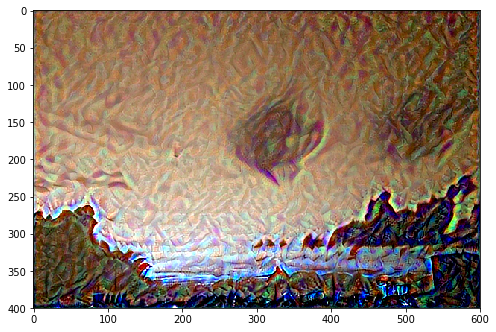

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(cv2.imread("./output/generated_2.png"),cv2.COLOR_BGR2RGB))